<a href="https://colab.research.google.com/github/brodyu/streamflow-forecasting-deep-learning/blob/main/colab_manoa_stream_lstm_bidirectional_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Streamflow Forecasting with Recurrent Neural Networks and Transfer Learning

This notebook implements several recurrent neural networks on streamflow data collected from Manoa Stream located in Honolulu, HI. The trained model weights are then transfered to other streams that lack credible streamflow discharge data (e.g. Wailupe Stream).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from datetime import datetime
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, LSTM, Bidirectional, GRU, RepeatVector, TimeDistributed
from keras.utils import np_utils
from keras.layers import Flatten
import seaborn as sns
import joblib
import tensorflow as tf
import keras
from scipy import stats
from keras.utils.vis_utils import plot_model

import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 706kB 13.5MB/s 


In [ ]:
# raw url link from GitHub repo: https://github.com/brodyu/streamflow-forecasting-deep-learning/blob/main/Manoa_reduced.csv

url = "https://raw.githubusercontent.com/brodyu/streamflow-forecasting-deep-learning/main/Manoa_reduced.csv"
df = pd.read_csv(url)
df.head()

,Date,Discharge,maxtempC,mintempC,sunHour,uvIndex,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,10/1/11,2.64,34,23,10.2,6,22,31,31,28,9,51,74,1.5,1009,34,9,304,6
1,10/2/11,2.63,32,23,8.8,6,23,30,30,27,5,60,84,4.8,1010,32,5,258,3
2,10/3/11,2.74,34,23,10.2,6,22,30,30,27,7,51,78,11.6,1010,34,7,160,4
3,10/4/11,5.92,37,21,11.6,8,19,30,30,28,6,22,63,0.0,1008,37,8,165,4
4,10/5/11,2.92,35,22,11.6,8,18,31,31,29,6,22,56,0.1,1009,35,10,105,4


In [ ]:
df = df.set_index("Date")
df.head()

,Discharge,maxtempC,mintempC,sunHour,uvIndex,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
Date,,,,,,,,,,,,,,,,,,
10/1/11,2.64,34,23,10.2,6,22,31,31,28,9,51,74,1.5,1009,34,9,304,6
10/2/11,2.63,32,23,8.8,6,23,30,30,27,5,60,84,4.8,1010,32,5,258,3
10/3/11,2.74,34,23,10.2,6,22,30,30,27,7,51,78,11.6,1010,34,7,160,4
10/4/11,5.92,37,21,11.6,8,19,30,30,28,6,22,63,0.0,1008,37,8,165,4
10/5/11,2.92,35,22,11.6,8,18,31,31,29,6,22,56,0.1,1009,35,10,105,4


In [ ]:
df['Discharge'] = df["Discharge"].rolling(window=3).mean()
df = df.iloc[2:]
print(df)

         Discharge  maxtempC  ...  winddirDegree  windspeedKmph
Date                          ...                              
10/3/11   2.670000        34  ...            160              4
10/4/11   3.763333        37  ...            165              4
10/5/11   3.860000        35  ...            105              4
10/6/11   3.950000        34  ...            161              4
10/7/11   3.270000        31  ...            248              4
...            ...       ...  ...            ...            ...
3/27/20  31.820000        28  ...            134              4
3/28/20  41.320000        34  ...            178              3
3/29/20  50.833333        29  ...            142              2
3/30/20  35.000000        29  ...            121              4
3/31/20  24.066667        32  ...            189              3

[3103 rows x 18 columns]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3103 entries, 10/3/11 to 3/31/20
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Discharge      3103 non-null   float64
 1   maxtempC       3103 non-null   int64  
 2   mintempC       3103 non-null   int64  
 3   sunHour        3103 non-null   float64
 4   uvIndex        3103 non-null   int64  
 5   DewPointC      3103 non-null   int64  
 6   FeelsLikeC     3103 non-null   int64  
 7   HeatIndexC     3103 non-null   int64  
 8   WindChillC     3103 non-null   int64  
 9   WindGustKmph   3103 non-null   int64  
 10  cloudcover     3103 non-null   int64  
 11  humidity       3103 non-null   int64  
 12  precipMM       3103 non-null   float64
 13  pressure       3103 non-null   int64  
 14  tempC          3103 non-null   int64  
 15  visibility     3103 non-null   int64  
 16  winddirDegree  3103 non-null   int64  
 17  windspeedKmph  3103 non-null   int64  
dtypes: f

In [ ]:
def outliers(df, int):
  z_scores = stats.zscore(df)
  abs_z_scores = np.abs(z_scores)
  filtered_entries = (abs_z_scores < int).all(axis=1)
  df = df[filtered_entries]
  return df

In [ ]:
def normalization(df):
  values = df.values
  # convert to floats
  values = values.astype('float64')
  # Normalization
  min_max_scaler = MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(values)
  values = pd.DataFrame(x_scaled)
  print(values)
  return values

In [ ]:
df = outliers(df, 3)
values = normalization(df)

            0     1         2         3   ...    14        15        16        17
0     0.030358  0.60  0.666667  0.623188  ...  0.60  0.428571  0.436578  0.428571
1     0.047321  0.75  0.444444  0.826087  ...  0.75  0.500000  0.451327  0.428571
2     0.048821  0.65  0.555556  0.826087  ...  0.65  0.642857  0.274336  0.428571
3     0.050217  0.60  0.555556  0.826087  ...  0.60  0.571429  0.439528  0.428571
4     0.039667  0.45  0.666667  0.623188  ...  0.45  0.571429  0.696165  0.428571
...        ...   ...       ...       ...  ...   ...       ...       ...       ...
2800  0.170821  0.45  0.777778  0.014493  ...  0.45  0.642857  0.404130  0.714286
2801  0.482623  0.30  0.666667  0.420290  ...  0.30  0.500000  0.359882  0.428571
2802  0.630017  0.60  0.666667  0.826087  ...  0.60  0.642857  0.489676  0.285714
2803  0.777617  0.35  0.666667  0.217391  ...  0.35  0.357143  0.383481  0.142857
2804  0.362329  0.50  0.666667  0.217391  ...  0.50  0.500000  0.522124  0.285714

[2805 rows x 18

In [ ]:
# lagging steps and features
backward_steps = 100
n_features = df.shape[1]

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
     # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# frame as supervised learning
reframed = series_to_supervised(values, backward_steps, 1)

In [ ]:
def train_test_split(reframed, backward_steps, n_features):
  # split into train and test sets
  values = reframed.values
  threshold = int(0.8 * len(reframed))
  train = values[:threshold, :]
  test = values[threshold:, :]

  # split into input and outputs
  n_obs = backward_steps * n_features
  train_X, train_y = train[:, :n_obs], train[:, -n_features]
  test_X, test_y = test[:, :n_obs], test[:, -n_features]
  print(train_X.shape, len(train_X), train_y.shape)

  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], backward_steps, n_features))
  test_X = test_X.reshape((test_X.shape[0], backward_steps, n_features))
  print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

  return train_X, train_y, test_X, test_y

In [ ]:
train_X, train_y, test_X, test_y = train_test_split(reframed, backward_steps, n_features)

(2164, 1800) 2164 (2164,)
(2164, 100, 18) (2164,) (541, 100, 18) (541,)


In [ ]:
# model Funnctions
# testing 

# create BiLSTM model
def create_model_bilstm(units):
  model = Sequential()
  model.add(Bidirectional(LSTM(units = units, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Bidirectional(LSTM(units = units)))
  model.add(Dense(1))
  #Compile model
  model.compile(optimizer='adam', loss='mae')
  return model

# create LSTM model
def create_model_lstm(units):
  model = Sequential()
  model.add(LSTM(units = units, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dropout(0.2))
  model.add(LSTM(units = units))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mae')
  return model

# create GRU model
def create_model_gru(units):
  model = Sequential()
  model.add(GRU(units = units, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dropout(0.2))
  model.add(GRU(units = units))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mae')
  return model

# BiLSTM
model_bilstm = create_model_bilstm(64)
# GRU and LSTM
model_gru = create_model_gru(64)
model_lstm = create_model_lstm(64)

In [ ]:
# fit BiLSTM, LSTM and GRU
def fit_model(model, int):
  early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
  history = model.fit(train_X, train_y, epochs = 60, validation_split = 0.2, batch_size = 72, shuffle = False, callbacks = [early_stop])
  model.save(f"model{int}")
  return history
history_bilstm = fit_model(model_bilstm, 1)
history_lstm = fit_model(model_lstm, 2)
history_gru = fit_model(model_gru, 3)

Epoch 1/60
25/25 [==============================] - 23s 93ms/step - loss: 0.2158 - val_loss: 0.1421
Epoch 2/60
25/25 [==============================] - 1s 30ms/step - loss: 0.1058 - val_loss: 0.1172
Epoch 3/60
25/25 [==============================] - 1s 28ms/step - loss: 0.0830 - val_loss: 0.1126
Epoch 4/60
25/25 [==============================] - 1s 29ms/step - loss: 0.0792 - val_loss: 0.1354
Epoch 5/60
25/25 [==============================] - 1s 29ms/step - loss: 0.0893 - val_loss: 0.1157
Epoch 6/60
25/25 [==============================] - 1s 29ms/step - loss: 0.0784 - val_loss: 0.1086
Epoch 7/60
25/25 [==============================] - 1s 29ms/step - loss: 0.0789 - val_loss: 0.1050
Epoch 8/60
25/25 [==============================] - 1s 29ms/step - loss: 0.0743 - val_loss: 0.0994
Epoch 9/60
25/25 [==============================] - 1s 31ms/step - loss: 0.0704 - val_loss: 0.0957
Epoch 10/60
25/25 [==============================] - 1s 29ms/step - loss: 0.0640 - val_loss: 0.1039
Epoch 11

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


Epoch 1/60
25/25 [==============================] - 4s 84ms/step - loss: 0.1672 - val_loss: 0.1161
Epoch 2/60
25/25 [==============================] - 0s 16ms/step - loss: 0.0917 - val_loss: 0.1158
Epoch 3/60
25/25 [==============================] - 0s 16ms/step - loss: 0.0835 - val_loss: 0.1062
Epoch 4/60
25/25 [==============================] - 0s 17ms/step - loss: 0.0773 - val_loss: 0.1059
Epoch 5/60
25/25 [==============================] - 0s 17ms/step - loss: 0.0759 - val_loss: 0.1062
Epoch 6/60
25/25 [==============================] - 0s 16ms/step - loss: 0.0769 - val_loss: 0.1018
Epoch 7/60
25/25 [==============================] - 0s 16ms/step - loss: 0.0731 - val_loss: 0.0999
Epoch 8/60
25/25 [==============================] - 0s 17ms/step - loss: 0.0692 - val_loss: 0.0998
Epoch 9/60
25/25 [==============================] - 0s 17ms/step - loss: 0.0695 - val_loss: 0.0999
Epoch 10/60
25/25 [==============================] - 0s 16ms/step - loss: 0.0716 - val_loss: 0.1012
Epoch 11/

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 1/60
25/25 [==============================] - 4s 41ms/step - loss: 0.1820 - val_loss: 0.1256
Epoch 2/60
25/25 [==============================] - 0s 16ms/step - loss: 0.1155 - val_loss: 0.1131
Epoch 3/60
25/25 [==============================] - 0s 15ms/step - loss: 0.0908 - val_loss: 0.1060
Epoch 4/60
25/25 [==============================] - 0s 16ms/step - loss: 0.0816 - val_loss: 0.1241
Epoch 5/60
25/25 [==============================] - 0s 16ms/step - loss: 0.0882 - val_loss: 0.0999
Epoch 6/60
25/25 [==============================] - 0s 17ms/step - loss: 0.0790 - val_loss: 0.0905
Epoch 7/60
25/25 [==============================] - 0s 15ms/step - loss: 0.0733 - val_loss: 0.0892
Epoch 8/60
25/25 [==============================] - 0s 16ms/step - loss: 0.0665 - val_loss: 0.0968
Epoch 9/60
25/25 [==============================] - 0s 16ms/step - loss: 0.0670 - val_loss: 0.0917
Epoch 10/60
25/25 [==============================] - 0s 16ms/step - loss: 0.0648 - val_loss: 0.0929
Epoch 11/

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


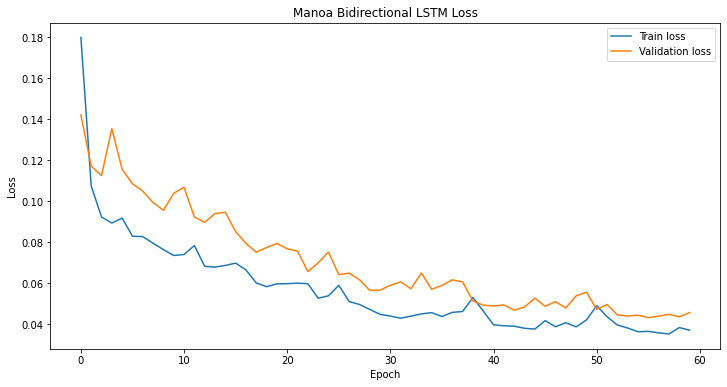

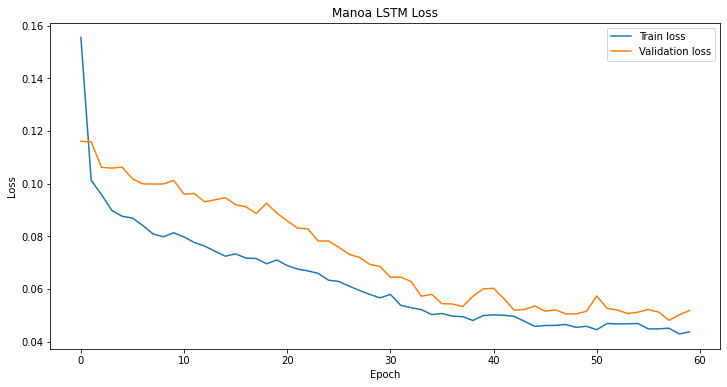

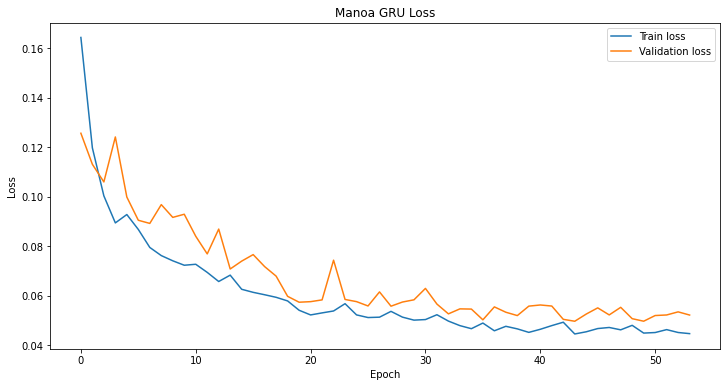

In [ ]:
# plot train loss and validation loss
def plot_loss (history, int, title):
  plt.figure(figsize = (12, 6))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train loss', 'Validation loss'], loc='upper right')
  plt.savefig(f"lossgraphs{int}.jpg")
  plt.show()
plot_loss (history_bilstm, 1, "Manoa Bidirectional LSTM Loss")
plot_loss (history_lstm, 2, "Manoa LSTM Loss")
plot_loss (history_gru, 3, "Manoa GRU Loss")

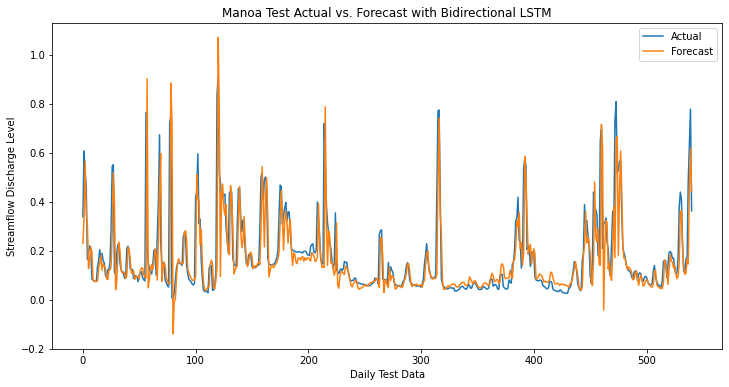

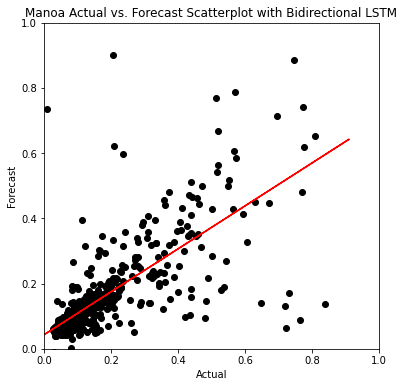

Test RMSE: 0.113
tf.Tensor(0.49605662, shape=(), dtype=float32)


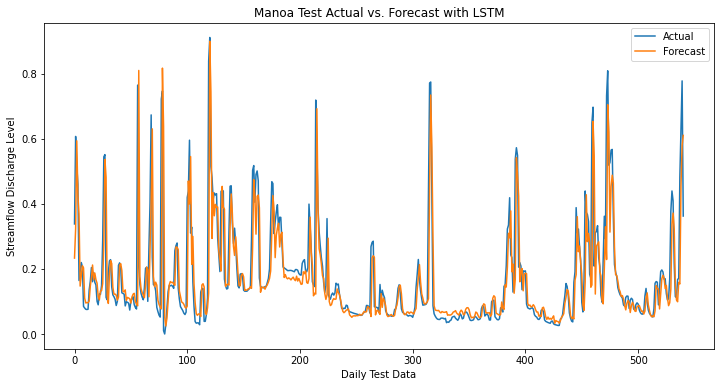

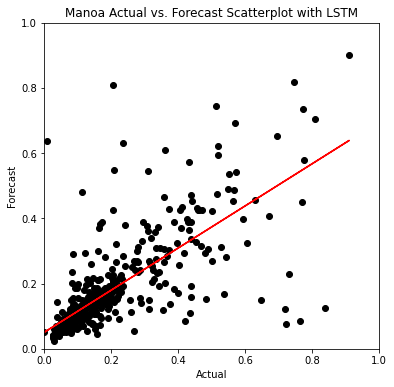

Test RMSE: 0.108
tf.Tensor(0.53770953, shape=(), dtype=float32)


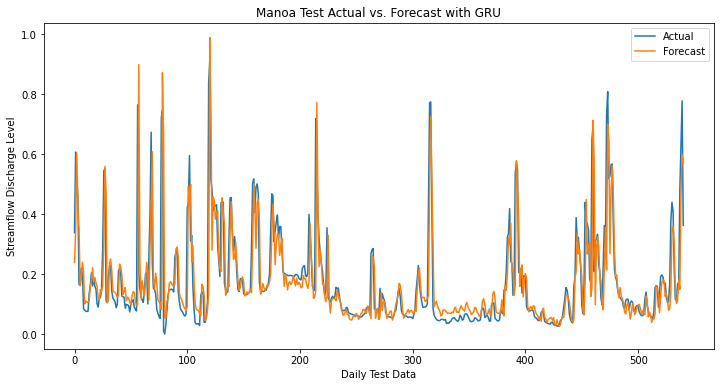

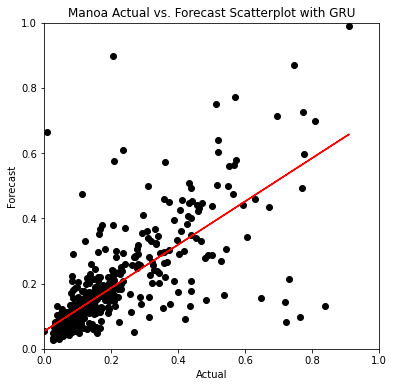

Test RMSE: 0.108
tf.Tensor(0.53487843, shape=(), dtype=float32)


In [ ]:
# predictions
def prediction(model, test_X, test_y, int, title, title2):
  # make a prediction
  yhat = model.predict(test_X)
  test_X = test_X.reshape((test_X.shape[0], backward_steps*n_features))
  # invert scaling for forecast
  inv_yhat = np.concatenate((yhat, test_X[:, -(n_features - 1):]), axis=1)
  inv_yhat = inv_yhat[:,0]
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = np.concatenate((test_y, test_X[:, -(n_features - 1):]), axis=1)
  inv_y = inv_y[:,0]
  # Prediction Plots
  plt.figure(figsize=(12, 6))
  plt.plot(inv_y, label='Actual')
  plt.plot(inv_yhat, label='Forecast')
  plt.title(title)
  plt.ylabel('Streamflow Discharge Level')
  plt.xlabel('Daily Test Data')
  plt.legend()
  plt.savefig(f"actual-forecastplot{int}.jpg")
  plt.show()
  # Scatter plot
  plt.figure(figsize=(6, 6))
  m, b = np.polyfit(inv_y, inv_yhat, 1)
  plt.plot(inv_y, inv_yhat, 'o', color='black')
  plt.plot(inv_y, m*(inv_y) + b, color='red')
  plt.title(title2)
  plt.ylabel('Forecast')
  plt.xlabel('Actual')
  plt.savefig(f"scatterplot{int}.jpg")
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.show()
  # calculate RMSE
  rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
  print('Test RMSE: %.3f' % rmse)

  metric = tfa.metrics.r_square.RSquare()
  metric.update_state(inv_y, inv_yhat)
  result = metric.result()
  result.numpy()
  print(result)
  
  return inv_y, inv_yhat
prediction_bilstm = prediction(model_bilstm, test_X, test_y, 1, "Manoa Test Actual vs. Forecast with Bidirectional LSTM", "Manoa Actual vs. Forecast Scatterplot with Bidirectional LSTM")
prediction_lstm = prediction(model_lstm, test_X, test_y, 2, "Manoa Test Actual vs. Forecast with LSTM", "Manoa Actual vs. Forecast Scatterplot with LSTM")
prediction_gru = prediction(model_gru, test_X, test_y, 3, "Manoa Test Actual vs. Forecast with GRU", "Manoa Actual vs. Forecast Scatterplot with GRU")

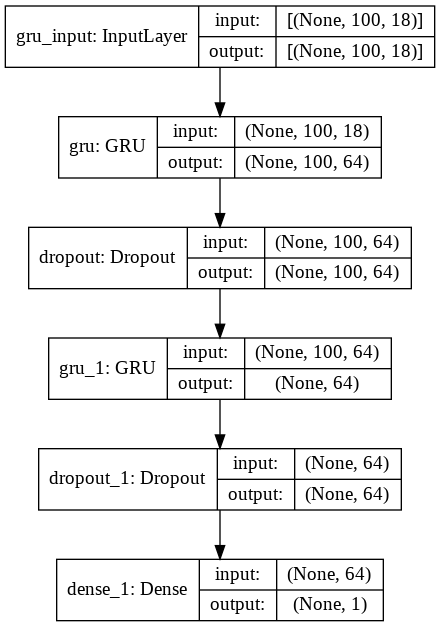

In [ ]:
tf.keras.utils.plot_model(model_bilstm, to_file='model_bilstm_plot.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(model_lstm, to_file='model_lstm_plot.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(model_gru, to_file='model_gru_plot.png', show_shapes=True, show_layer_names=True)

## Transfer Learning GRU Model to Palolo Stream

In [ ]:
reconstructed_model = keras.models.load_model("model2")

In [ ]:
url = "https://raw.githubusercontent.com/brodyu/streamflow-forecasting-deep-learning/main/Palolo.csv"
df_palolo = pd.read_csv(url)
df_palolo.head()

,Date,Discharge,maxtempC,mintempC,sunHour,uvIndex,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,4/9/10,0.81,27,23,12.0,5,23,27,27,24,6,45,92,2.9,1011,27,7,194,4
1,4/10/10,0.77,27,22,12.5,6,23,28,28,25,7,42,88,3.8,1010,27,8,265,5
2,4/11/10,0.81,29,23,12.5,6,23,29,29,25,8,44,88,5.3,1010,29,10,181,5
3,4/12/10,0.81,27,22,12.5,5,22,27,27,24,8,48,91,3.7,1011,27,9,212,5
4,4/13/10,1.70,25,23,10.5,5,23,27,27,24,5,63,92,3.2,1011,25,9,98,3


In [ ]:
df_palolo = df_palolo.set_index("Date")
df_palolo.head()

,Discharge,maxtempC,mintempC,sunHour,uvIndex,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
Date,,,,,,,,,,,,,,,,,,
4/9/10,0.81,27,23,12.0,5,23,27,27,24,6,45,92,2.9,1011,27,7,194,4
4/10/10,0.77,27,22,12.5,6,23,28,28,25,7,42,88,3.8,1010,27,8,265,5
4/11/10,0.81,29,23,12.5,6,23,29,29,25,8,44,88,5.3,1010,29,10,181,5
4/12/10,0.81,27,22,12.5,5,22,27,27,24,8,48,91,3.7,1011,27,9,212,5
4/13/10,1.70,25,23,10.5,5,23,27,27,24,5,63,92,3.2,1011,25,9,98,3


In [ ]:
df_palolo['Discharge'] = df_palolo["Discharge"].rolling(window=3).mean()
df_palolo = df_palolo.iloc[2:]
print(df_palolo)

         Discharge  maxtempC  ...  winddirDegree  windspeedKmph
Date                          ...                              
4/11/10   0.796667        29  ...            181              5
4/12/10   0.796667        27  ...            212              5
4/13/10   1.106667        25  ...             98              3
4/14/10   1.236667        24  ...            160              5
4/15/10   1.293333        28  ...            246              5
...            ...       ...  ...            ...            ...
1/7/21    0.546667        28  ...            253              3
1/8/21    0.513333        27  ...            230              3
1/9/21    0.500000        31  ...            198              4
1/10/21   0.510000        31  ...            201              4
1/11/21   0.510000        32  ...            225              4

[3929 rows x 18 columns]


In [ ]:
# Data Preprocessing
df_palolo = outliers(df_palolo, 3)
values_palolo = normalization(df_palolo)

            0         1         2         3   ...        14   15        16   17
0     0.054915  0.555556  0.666667  1.000000  ...  0.555556  0.6  0.465950  0.6
1     0.054915  0.333333  0.500000  1.000000  ...  0.333333  0.4  0.577061  0.6
2     0.083131  0.111111  0.666667  0.692308  ...  0.111111  0.4  0.168459  0.2
3     0.100121  0.444444  0.500000  1.000000  ...  0.444444  0.2  0.698925  0.6
4     0.072816  0.000000  0.666667  0.276923  ...  0.000000  0.0  0.501792  0.6
...        ...       ...       ...       ...  ...       ...  ...       ...  ...
3567  0.032160  0.444444  0.500000  0.938462  ...  0.444444  0.4  0.724014  0.2
3568  0.029126  0.333333  0.833333  0.215385  ...  0.333333  0.4  0.641577  0.2
3569  0.027913  0.777778  0.666667  0.430769  ...  0.777778  0.6  0.526882  0.4
3570  0.028823  0.777778  0.833333  0.430769  ...  0.777778  0.6  0.537634  0.4
3571  0.028823  0.888889  1.000000  0.430769  ...  0.888889  0.6  0.623656  0.4

[3572 rows x 18 columns]


In [ ]:
# frame as supervised learning
reframed_palolo = series_to_supervised(values_palolo, backward_steps, 1)

In [ ]:
palolotrain_X, palolotrain_y, palolotest_X, palolotest_y = train_test_split(reframed_palolo, backward_steps, n_features)

(2777, 1800) 2777 (2777,)
(2777, 100, 18) (2777,) (695, 100, 18) (695,)


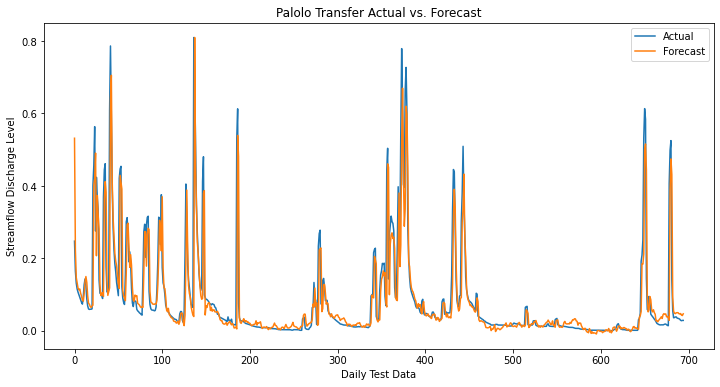

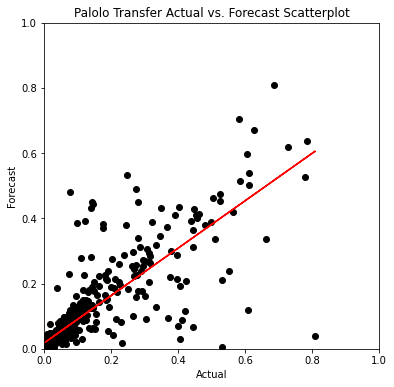

Test RMSE: 0.076
tf.Tensor(0.6854012, shape=(), dtype=float32)


In [ ]:
paloloinv_y, paloloinv_yhat = prediction(reconstructed_model, palolotest_X, palolotest_y, 4, "Palolo Transfer Actual vs. Forecast", "Palolo Transfer Actual vs. Forecast Scatterplot")

## Transfer Learning GRU Model to Makiki Stream

In [ ]:
url = "https://raw.githubusercontent.com/brodyu/streamflow-forecasting-deep-learning/main/Makiki.csv"
df_makiki = pd.read_csv(url)
df_makiki.head()

,Date,Discharge,maxtempC,mintempC,sunHour,uvIndex,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2/20/10,0.59,25,18,10.2,5,20,22,22,21,9,62,91,3.3,1010,25,7,277,6
1,2/21/10,0.58,22,18,8.8,5,19,20,21,20,9,77,97,2.7,1010,22,5,303,6
2,2/22/10,0.58,25,17,10.2,5,19,22,22,21,10,67,92,4.9,1010,25,6,255,6
3,2/23/10,0.61,25,17,10.2,5,19,21,21,20,7,68,93,4.1,1011,25,6,180,4
4,2/24/10,0.66,26,17,10.2,5,19,21,21,21,4,68,93,3.9,1010,26,5,107,2


In [ ]:
df_makiki = df_makiki.set_index("Date")
df_makiki.head()

,Discharge,maxtempC,mintempC,sunHour,uvIndex,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
Date,,,,,,,,,,,,,,,,,,
2/20/10,0.59,25,18,10.2,5,20,22,22,21,9,62,91,3.3,1010,25,7,277,6
2/21/10,0.58,22,18,8.8,5,19,20,21,20,9,77,97,2.7,1010,22,5,303,6
2/22/10,0.58,25,17,10.2,5,19,22,22,21,10,67,92,4.9,1010,25,6,255,6
2/23/10,0.61,25,17,10.2,5,19,21,21,20,7,68,93,4.1,1011,25,6,180,4
2/24/10,0.66,26,17,10.2,5,19,21,21,21,4,68,93,3.9,1010,26,5,107,2


In [ ]:
df_makiki['Discharge'] = df_makiki["Discharge"].rolling(window=3).mean()
df_makiki = df_makiki.iloc[2:]
print(df_makiki)

         Discharge  maxtempC  ...  winddirDegree  windspeedKmph
Date                          ...                              
2/22/10   0.583333        25  ...            255              6
2/23/10   0.590000        25  ...            180              4
2/24/10   0.616667        26  ...            107              2
2/25/10   0.653333        20  ...             89              4
2/26/10   0.690000        23  ...            113              4
...            ...       ...  ...            ...            ...
1/7/21    0.420000        22  ...            263              8
1/8/21    0.363333        22  ...            273             10
1/9/21    0.333333        18  ...            230              4
1/10/21   0.353333        19  ...            305              5
1/11/21   0.353333        20  ...            303              7

[3977 rows x 18 columns]


In [ ]:
# Data Preprocessing
df_makiki = outliers(df_makiki, 3)
values_makiki = normalization(df_makiki)

            0         1         2   ...        15        16        17
0     0.036675  0.411765  0.555556  ...  0.222222  0.718850  0.266667
1     0.037152  0.411765  0.555556  ...  0.222222  0.479233  0.133333
2     0.039057  0.470588  0.555556  ...  0.111111  0.246006  0.000000
3     0.041677  0.117647  0.555556  ...  0.000000  0.188498  0.133333
4     0.046916  0.411765  0.555556  ...  0.111111  0.386581  0.200000
...        ...       ...       ...  ...       ...       ...       ...
3635  0.030960  0.176471  0.000000  ...  0.333333  0.728435  0.333333
3636  0.030722  0.058824  0.444444  ...  0.444444  0.549521  0.133333
3637  0.024291  0.117647  0.333333  ...  0.555556  0.728435  0.266667
3638  0.026435  0.235294  0.444444  ...  0.555556  0.830671  0.200000
3639  0.018814  0.000000  0.333333  ...  0.333333  0.638978  0.133333

[3640 rows x 18 columns]


In [ ]:
# frame as supervised learning
reframed_makiki = series_to_supervised(values_makiki, backward_steps, 1)

In [ ]:
makikitrain_X, makikitrain_y, makikitest_X, makikitest_y = train_test_split(reframed_makiki, backward_steps, n_features)

(2832, 1800) 2832 (2832,)
(2832, 100, 18) (2832,) (708, 100, 18) (708,)


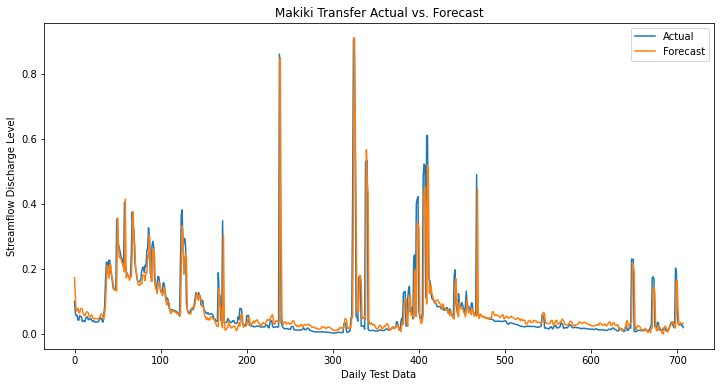

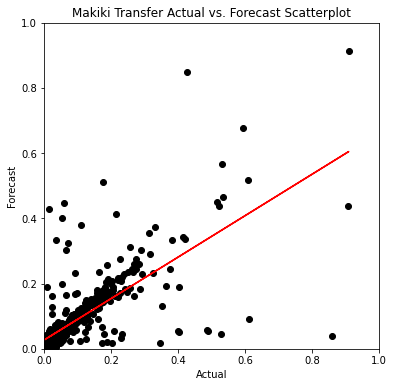

Test RMSE: 0.075
tf.Tensor(0.5263798, shape=(), dtype=float32)


In [ ]:
makikiinv_y, makikiinv_yhat = prediction(reconstructed_model, makikitest_X, makikitest_y, 5, "Makiki Transfer Actual vs. Forecast", "Makiki Transfer Actual vs. Forecast Scatterplot")